In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.special import erf

import transport_signal_processing as tsp
from data_manager import DataManager

## Select and load events

In [3]:
# parameters
path = path = "K238A_20C_*0mV_*Oxytocin*"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# add full condition key
#df['condition'] = df.apply(lambda x: "{}-{}-{}".format(x['pore'], x['analyte'], x['voltage']), axis=1)
#df['condition'] = df.apply(lambda x: "{}-{}-{}".format(x['pore'], x['analyte'], x['voltage']), axis=1)

# mininum number of events
#df = df[df['N_cores']*df['ratio_sel'] > 200]

# keep only selected segments
df = df[(df['selected'] > (level-1))]
df

,pore,temperature,voltage,polymer_name,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel
0,K238A,20,100,10uMOxytocin-4MKCl,002,11,0,"[0, 3445965]",34.45965,2022-11-28_13:18:22,231.720795,3.359786,880,583.0,583.0,1.0,0.034305
1,K238A,20,100,10uMOxytocin-4MKCl,002,11,1,"[3487777, 5011263]",15.23486,2022-11-28_13:18:22,232.621758,3.443675,454,309.0,309.0,1.0,0.035599
2,K238A,20,100,10uMOxytocin-4MKCl,002,11,2,"[5067500, 11575970]",65.08470,2022-11-28_13:18:22,233.176229,3.507675,1668,1114.0,1114.0,1.0,0.061041
3,K238A,20,100,10uMOxytocin-4MKCl,002,11,3,"[11598717, 13638612]",20.39895,2022-11-28_13:18:22,233.815446,3.575590,227,155.0,155.0,1.0,0.045161
5,K238A,20,100,10uMOxytocin-4MKCl,002,11,5,"[14377613, 15464141]",10.86528,2022-11-28_13:18:22,234.257159,3.640482,109,74.0,74.0,1.0,0.040541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,K238A,20,90,10uMOxytocin-4MKCl,004,8-20221811-1,3,"[12788684, 13249919]",4.61235,2022-11-28_13:18:23,231.931730,3.224790,106,70.0,70.0,1.0,0.042857
717,K238A,20,90,10uMOxytocin-4MKCl,004,5,0,"[0, 15496421]",154.96421,2022-11-28_13:18:23,213.319881,3.187146,5901,3542.0,3542.0,1.0,0.042914
719,K238A,20,90,10uMOxytocin-4MKCl,004,5,2,"[15685394, 33419447]",177.34053,2022-11-28_13:18:23,213.325589,3.190412,6900,4125.0,4125.0,1.0,0.040970
720,K238A,20,90,10uMOxytocin-4MKCl,004,5,3,"[33440443, 34220830]",7.80387,2022-11-28_13:18:23,213.578897,3.226571,217,137.0,137.0,1.0,0.036496


In [4]:
# parameters
key_sel = 'voltage'

# load stats grouped by selected key
stats_dict = tsp.utils.load_stats_for_key(sigman, df.to_dict('records'), key_sel, selected_only=selected_only)

# find keys
key_sels = np.unique(df[key_sel].values)

events_dict = {}
for key in tqdm(key_sels):
    # subset
    dfs = df[df[key_sel] == key].copy()

    # load core events
    events_dict[key] = tsp.utils.load_core_events(sigman, dfs.to_dict('record'), selected_only=selected_only)

  0%|          | 0/4 [00:00<?, ?it/s]/home/lfkrapp/anaconda3/envs/tsp/lib/python3.9/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


In [5]:
def load_range_events(sigman, sinfo_l):
    # load core events
    rngs_all = []
    for i in range(len(sinfo_l)):
        # get path within the database
        sinfo = sinfo_l[i]
        curr_path = sigman.define_db_path(sinfo)

        # load cores & reduced and filter keep only selected ones
        r = sigman.load_data(curr_path, 's{}-events-range'.format(sinfo['sid']))[0]

        # append data
        rngs_all += list(r)
        
    return rngs_all

In [7]:
# parameters
key_sel = 'voltage'

# load stats grouped by selected key
stats_dict = tsp.utils.load_stats_for_key(sigman, df.to_dict('records'), key_sel, selected_only=selected_only)

# find keys
key_sels = np.unique(df[key_sel].values)

ranges_dict = {}
for key in tqdm(key_sels):
    # subset
    dfs = df[df[key_sel] == key].copy()

    # load core events
    ranges_dict[key] = load_range_events(sigman, dfs.to_dict('record'))

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


## Conditions

## t$_{on}$ / t$_{off}$

In [8]:
def exp_fct(x, a, b):
    return a*np.exp(-b*x)

def exp_dist_fit(t, xlims, bins):
    # dwell time fit
    h, dwt = np.histogram(t, range=xlims, bins=bins)
    #h = h / np.sum(h)
    dwt = 0.5*(dwt[:-1] + dwt[1:])

    i0, i1 = np.argmax(h), np.argmin(h)
    i1 = len(h)-1
    xv = dwt[i0:i1]
    yv = h[i0:i1] # / np.max(h[i0:i1])

    popt, pcov = curve_fit(exp_fct, xv, yv, p0=(1.0,0.1))

    x = np.linspace(dwt[i0], dwt[i1])
    y = exp_fct(x, popt[0], popt[1])

    a = popt[1]
    err = np.sqrt(pcov[1][1])/np.square(popt[1])
    
    return x, y, a, err

In [9]:
def gauss_fct(x, A, mu, sigma):
    return np.abs(A) * np.exp(-np.square((x - mu))/np.square(sigma))

def gauss_dist_fit(t, xlims, bins):
    # dwell time fit
    h, dwt = np.histogram(t, range=xlims, bins=bins)
    #h = h / np.sum(h)
    dwt = 0.5*(dwt[:-1] + dwt[1:])

    i0, i1 = np.argmax(h), np.argmin(h)
    i1 = len(h)-1
    xv = dwt[i0:i1]
    yv = h[i0:i1] # / np.max(h[i0:i1])

    popt, pcov = curve_fit(gauss_fct, xv, yv, p0=(1.0,0.1,1.0))

    x = np.linspace(dwt[i0], dwt[i1])
    y = gauss_fct(x, popt[0], popt[1], popt[2])

    a = popt[1]
    err = np.sqrt(pcov[1,1])
    
    return x, y, np.power(10,a), np.log(10.0)*np.power(10,a)*err

100


<ipython-input-8-04f4bb5cedcd>:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)


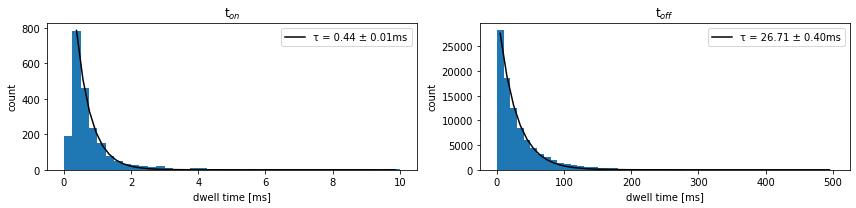

<ipython-input-10-df92ae64d6b2>:58: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_on, np.log10(h_on), '.-')


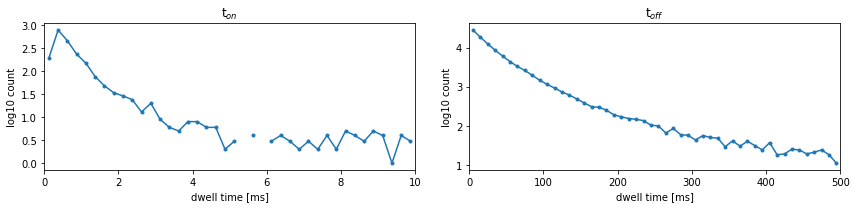

110


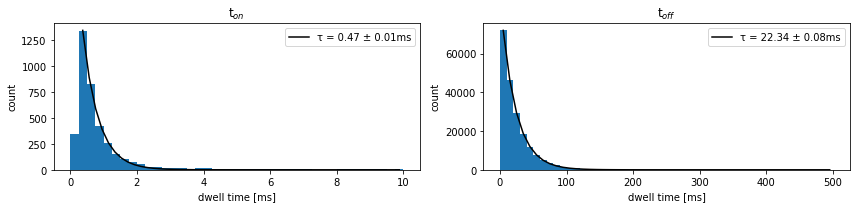

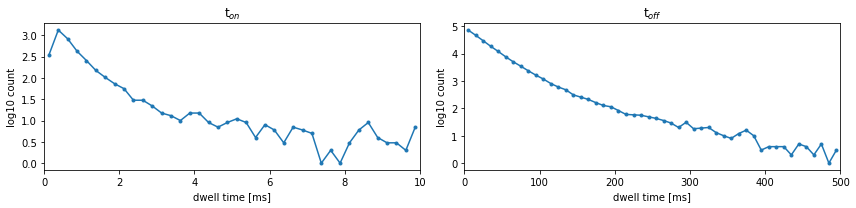

140


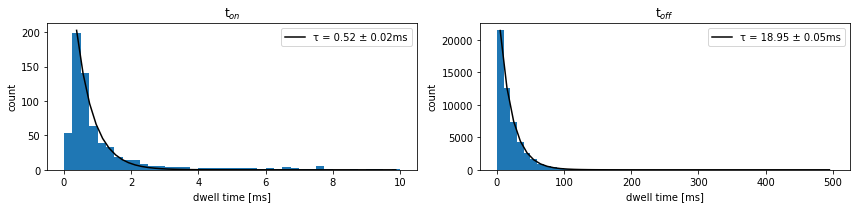

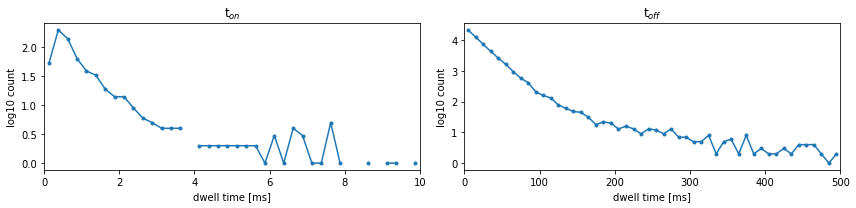

90


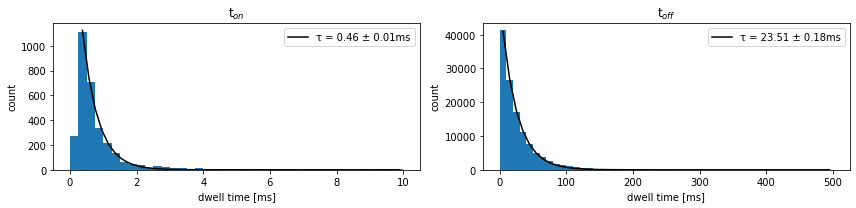

<ipython-input-10-df92ae64d6b2>:65: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_off, np.log10(h_off), '.-')


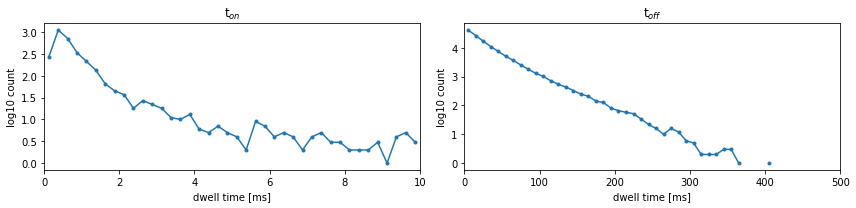

In [10]:
# parameters
dt = 1e-5
xlims_on = (0.0, 10.0)
xlims_off = (0.0, 500.0)
bins_on = 40
bins_off = 50

lxlims_on = (-1.0, 3.0)
lxlims_off = (0.0, 5.0)
lbins_on = 80
lbins_off = 50

results = []
for key in ranges_dict:
    print(key)
    rngs = np.array(ranges_dict[key])
    events = events_dict[key]
    
    results.append({'name':key})
    
    #dwt_on = 1e3*dt*(rngs[:,1] - rngs[:,0])
    dwt_on = np.array([evt[-1,0]-evt[0,0] for evt in events if len(evt) > 1])
    dwt_off = 1e3*dt*(rngs[1:,0]-rngs[:-1,1])

    x_on, y_on, a_on, err_on = exp_dist_fit(dwt_on, xlims_on, bins_on)
    x_off, y_off, a_off, err_off = exp_dist_fit(dwt_off, xlims_off, bins_off)
    
    results[-1]['exp_t'] = 1.0/a_on

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.hist(dwt_on, range=xlims_on, bins=bins_on)
    plt.plot(x_on, y_on, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a_on, err_on))
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    plt.title('t$_{on}$')

    plt.subplot(122)
    plt.hist(dwt_off, range=xlims_off, bins=bins_off)
    plt.plot(x_off, y_off, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a_off, err_off))
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    plt.title('t$_{off}$')
    plt.tight_layout()
    plt.savefig("graphs/dwt_exp_fit_{}.png".format(key), dpi=200)
    plt.show()

    h_on, x_on = np.histogram(dwt_on, range=xlims_on, bins=bins_on)
    x_on = 0.5*(x_on[:-1] + x_on[1:])

    h_off, x_off = np.histogram(dwt_off, range=xlims_off, bins=bins_off)
    x_off = 0.5*(x_off[:-1] + x_off[1:])

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.plot(x_on, np.log10(h_on), '.-')
    plt.xlim(xlims_on)
    plt.xlabel('dwell time [ms]')
    plt.ylabel('log10 count')
    plt.title('t$_{on}$')

    plt.subplot(122)
    plt.plot(x_off, np.log10(h_off), '.-')
    plt.xlim(xlims_off)
    plt.xlabel('dwell time [ms]')
    plt.ylabel('log10 count')
    plt.title('t$_{off}$')
    plt.tight_layout()
    plt.savefig("graphs/dwt_log_count_{}.png".format(key), dpi=200)
    plt.show()

    if False:
        ldwt_on = np.log10(dwt_on)
        ldwt_off = np.log10(dwt_off)

        x_on, y_on, a_on, err_on = gauss_dist_fit(ldwt_on, lxlims_on, lbins_on)
        x_off, y_off, a_off, err_off = gauss_dist_fit(ldwt_off, lxlims_off, lbins_off)

        results[-1]['gauss_t'] = a_on

        plt.figure(figsize=(12,3))
        plt.subplot(121)
        plt.hist(ldwt_on, range=lxlims_on, bins=lbins_on)
        plt.plot(x_on, y_on, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(a_on, err_on))
        plt.legend(loc='best')
        plt.xlabel('log10 dwell time [ms]')
        plt.ylabel('count')
        plt.title('t$_{on}$')

        plt.subplot(122)
        plt.hist(ldwt_off, range=lxlims_off, bins=lbins_off)
        plt.plot(x_off, y_off, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(a_off, err_off))
        plt.legend(loc='best')
        plt.xlabel('log10 dwell time [log10 ms]')
        plt.ylabel('count')
        plt.title('t$_{off}$')
        plt.tight_layout()
        #plt.savefig("graphs/dwt_gauss_fit_{}.png".format(key), dpi=200)
        plt.show()

In [11]:
df = pd.DataFrame(results)
df['pore'] = [v.split('-')[0] for v in df['name'].values]
df['analyte'] = [v.split('-')[1] for v in df['name'].values]
df['voltage'] = [int(v.split('-')[2]) for v in df['name'].values]
df

IndexError: list index out of range

In [10]:
df['analyte'].unique()

array(['MP446_P3_2'], dtype=object)

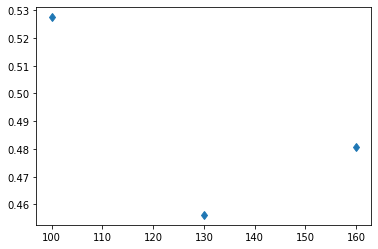

In [11]:
plt.figure()
for an in df['analyte'].unique():
    dfa = df[df['analyte'] == an]
    met = np.array([dfa[dfa['voltage'] == v]['exp_t'].mean() for v in np.sort(dfa['voltage'].unique())])
    #mgt = np.array([dfa[dfa['voltage'] == v]['gauss_t'].mean() for v in np.sort(dfa['voltage'].unique())])
    v = np.sort(dfa['voltage'].unique())
    plt.plot(v, met, 'd')
    #plt.plot(v, mgt, 's')
plt.show()

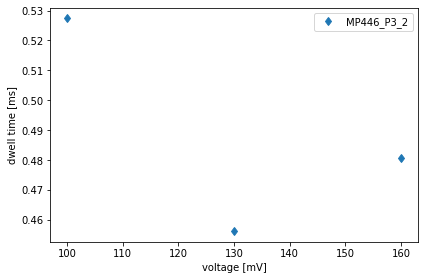

In [12]:
plt.figure()
for an in df['analyte'].unique():
    dfa = df[df['analyte'] == an]
    met = np.array([dfa[dfa['voltage'] == v]['exp_t'].mean() for v in np.sort(dfa['voltage'].unique())])
    v = np.sort(dfa['voltage'].unique())
    plt.plot(v, met, 'd', label=an)
plt.legend(loc='best')
plt.xlabel('voltage [mV]')
plt.ylabel('dwell time [ms]')
plt.tight_layout()
plt.savefig("graphs/dwell_time_exp_fit.png", dpi=200)
plt.show()

100


<ipython-input-8-04f4bb5cedcd>:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)


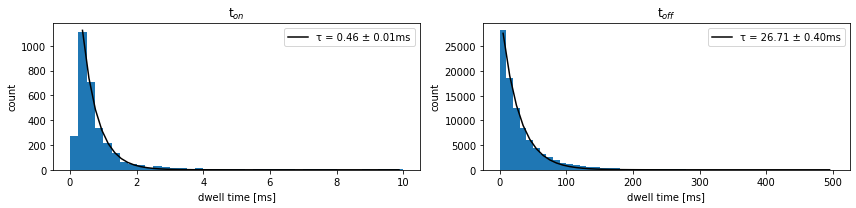

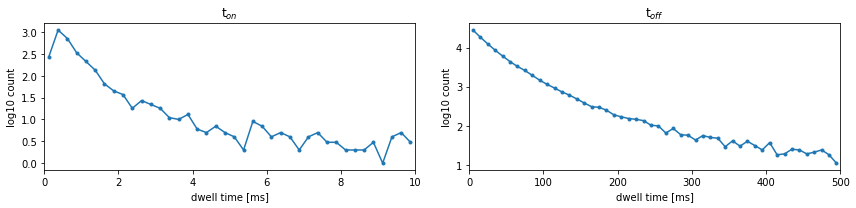

110


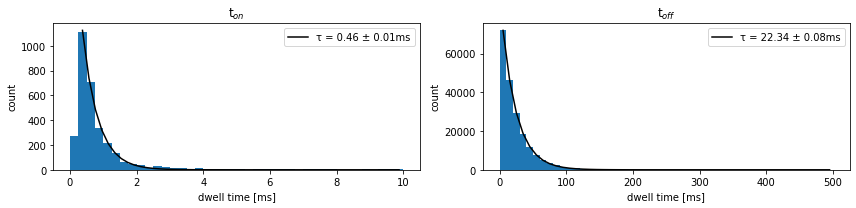

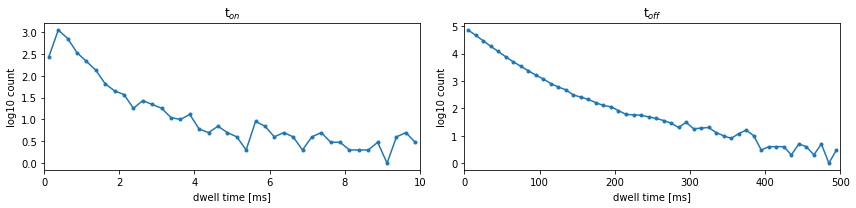

140


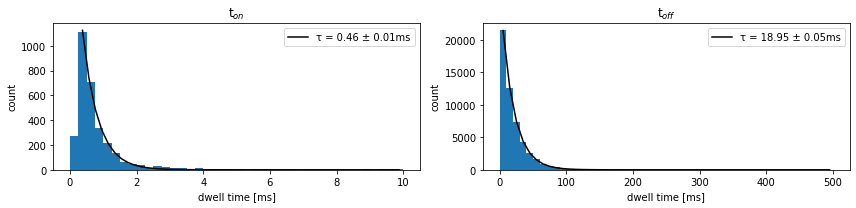

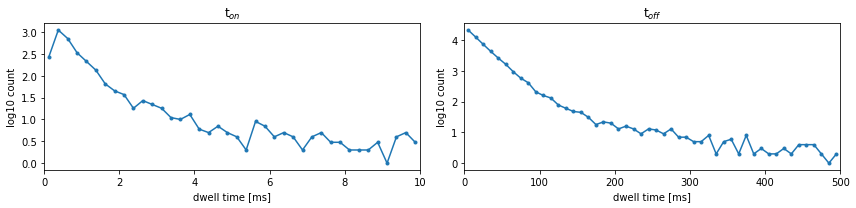

90


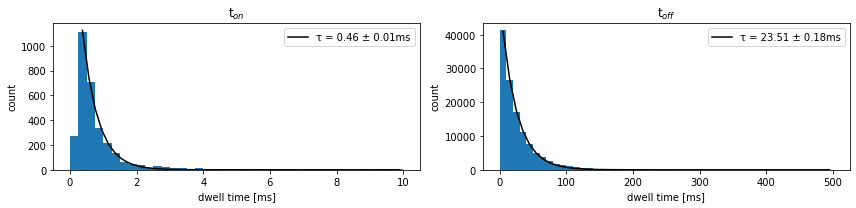

<ipython-input-12-b06218072c68>:51: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_off, np.log10(h_off), '.-')


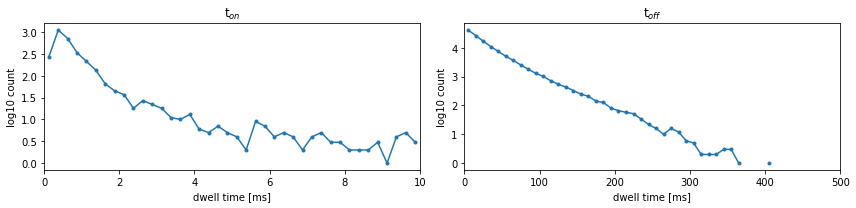

In [12]:
for key in ranges_dict:
    print(key)
    rngs = np.array(ranges_dict[key])
    events = events_dict[key]
    
    results.append({'name':key})
    
    dwt = np.array([evt[-1,0]-evt[0,0] for evt in events if len(evt) > 1])
    dwt_off = 1e3*dt*(rngs[1:,0]-rngs[:-1,1])

    x_on, y_on, a_on, err_on = exp_dist_fit(dwt_on, xlims_on, bins_on)
    x_off, y_off, a_off, err_off = exp_dist_fit(dwt_off, xlims_off, bins_off)
    
    results[-1]['exp_t'] = 1.0/a_on

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.hist(dwt_on, range=xlims_on, bins=bins_on)
    plt.plot(x_on, y_on, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a_on, err_on))
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    plt.title('t$_{on}$')

    plt.subplot(122)
    plt.hist(dwt_off, range=xlims_off, bins=bins_off)
    plt.plot(x_off, y_off, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a_off, err_off))
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    plt.title('t$_{off}$')
    plt.tight_layout()
    plt.savefig("graphs/dwt_exp_fit_{}.png".format(key), dpi=200)
    plt.show()

    h_on, x_on = np.histogram(dwt_on, range=xlims_on, bins=bins_on)
    x_on = 0.5*(x_on[:-1] + x_on[1:])

    h_off, x_off = np.histogram(dwt_off, range=xlims_off, bins=bins_off)
    x_off = 0.5*(x_off[:-1] + x_off[1:])

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.plot(x_on, np.log10(h_on), '.-')
    plt.xlim(xlims_on)
    plt.xlabel('dwell time [ms]')
    plt.ylabel('log10 count')
    plt.title('t$_{on}$')

    plt.subplot(122)
    plt.plot(x_off, np.log10(h_off), '.-')
    plt.xlim(xlims_off)
    plt.xlabel('dwell time [ms]')
    plt.ylabel('log10 count')
    plt.title('t$_{off}$')
    plt.tight_layout()
    plt.savefig("graphs/dwt_log_count_{}.png".format(key), dpi=200)
    plt.show()